In [1]:
import pandas as pd

FILE_NAME = "emission_data.csv"

emissions_all = pd.read_csv(FILE_NAME)

print(f"{len(emissions_all)} rows in dataset")

emissions_all.head()

23708 rows in dataset


,iso_code,country,year,co2,co2_growth_prct,co2_growth_abs,consumption_co2,trade_co2,trade_co2_share,co2_per_capita,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,primary_energy_consumption,energy_per_capita,energy_per_gdp,population,gdp
0,AFG,Afghanistan,1949,0.015,NaN,NaN,NaN,NaN,NaN,0.002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7663783.0,NaN
1,AFG,Afghanistan,1950,0.084,475.000,0.070,NaN,NaN,NaN,0.011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7752000.0,1.949480e+10
2,AFG,Afghanistan,1951,0.092,8.696,0.007,NaN,NaN,NaN,0.012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7840000.0,2.006385e+10
3,AFG,Afghanistan,1952,0.092,NaN,NaN,NaN,NaN,NaN,0.012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7936000.0,2.074235e+10
4,AFG,Afghanistan,1953,0.106,16.000,0.015,NaN,NaN,NaN,0.013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8040000.0,2.201546e+10


In [2]:
emissions_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 55 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   iso_code                             20930 non-null  object 
 1   country                              23708 non-null  object 
 2   year                                 23708 non-null  int64  
 3   co2                                  23170 non-null  float64
 4   co2_growth_prct                      21910 non-null  float64
 5   co2_growth_abs                       22017 non-null  float64
 6   consumption_co2                      3350 non-null   float64
 7   trade_co2                            3318 non-null   float64
 8   trade_co2_share                      3318 non-null   float64
 9   co2_per_capita                       22383 non-null  float64
 10  consumption_co2_per_capita           3350 non-null   float64
 11  share_global_co2            

In [3]:
# Clean it up

emissions_all = emissions_all[["country", "year", "co2"]]

emissions_all.head()

,country,year,co2
0,Afghanistan,1949,0.015
1,Afghanistan,1950,0.084
2,Afghanistan,1951,0.092
3,Afghanistan,1952,0.092
4,Afghanistan,1953,0.106


In [4]:
# Create Dataframe for country emissions
COUNTRY = "China"

emissions_country = emissions_all.loc[emissions_all["country"] == COUNTRY]

emissions_country = emissions_country.drop(columns=["country"])

emissions_country = emissions_country.reset_index(drop=True)

emissions_country = emissions_country.rename(columns={"year": "ds", "co2": "y"})

emissions_country["ds"] = pd.to_datetime(emissions_country["ds"], format="%Y")

emissions_country.head()

,ds,y
0,1899-01-01,0.095
1,1902-01-01,0.095
2,1903-01-01,1.964
3,1904-01-01,2.088
4,1905-01-01,2.297


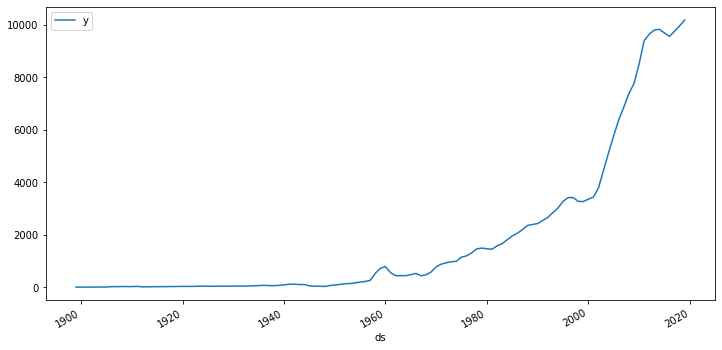

In [5]:
emissions_country.plot(kind="line", x="ds", y="y", figsize=(12,6));

In [6]:
# Create Dataframe for global emissions

emissions_global = emissions_all.drop(columns=["country"])

emissions_global = emissions_global.groupby("year").sum()

emissions_global = emissions_global.reset_index().rename(columns={
    "year": "ds",
    "co2": "y"
})

emissions_global["ds"] = pd.to_datetime(emissions_global["ds"], format="%Y")

emissions_global.head()

,ds,y
0,1750-01-01,46.755
1,1751-01-01,46.755
2,1752-01-01,46.770
3,1753-01-01,46.770
4,1754-01-01,46.790


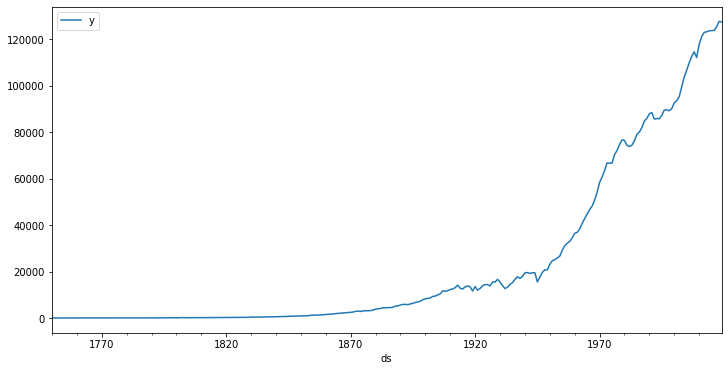

In [7]:
emissions_global.plot(kind="line", x="ds", y="y", figsize=(12,6));

In [8]:
# Define prophet utilities

from prophet import Prophet

def fit_prophet(data):
    prophet = Prophet(
        growth="linear",
        seasonality_mode="additive",
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )

    prophet.fit(data)
    
    return prophet

def predict_future_yearly(prophet, periods):
    return prophet.predict(
        prophet.make_future_dataframe(
            freq='Y',
            periods=periods,
            include_history=False
        )
    )

def combine_history_with_forecast(history, forecast):
    result = history.append(history.tail(1).rename(columns = {"y": "yhat"}))
    result = result.append(forecast).reset_index()
    result["year"] = result["ds"].dt.strftime("%Y")
    return result

In [9]:
prophet_country = fit_prophet(emissions_country)
prophet_global = fit_prophet(emissions_global)

print("Prophets fitted")

Prophets fitted


In [10]:
TARGET_YEAR = 2040

periods = TARGET_YEAR - int(emissions_all["year"].max())

forecast_global = predict_future_yearly(prophet_global, periods)
forecast_country = predict_future_yearly(prophet_country, periods)

combined_global = combine_history_with_forecast(emissions_global, forecast_global)
combined_country = combine_history_with_forecast(emissions_country, forecast_country)

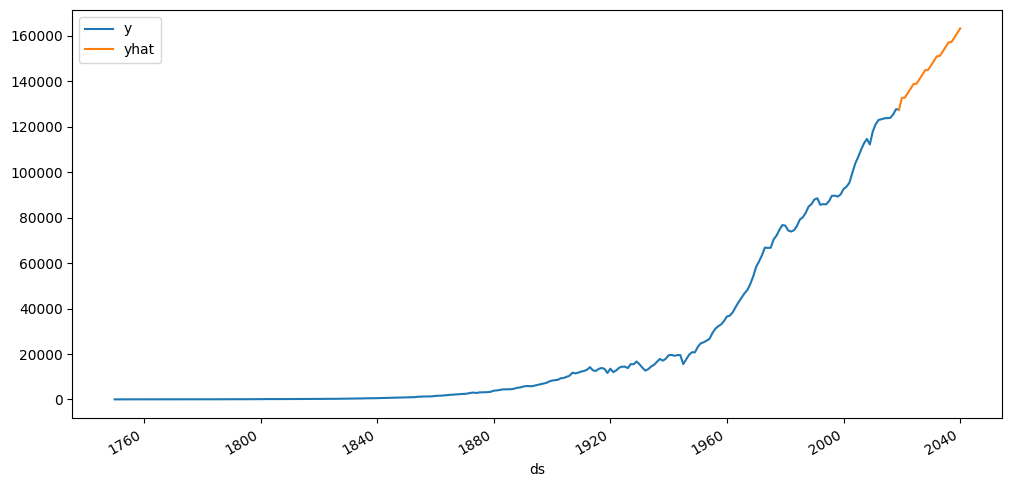

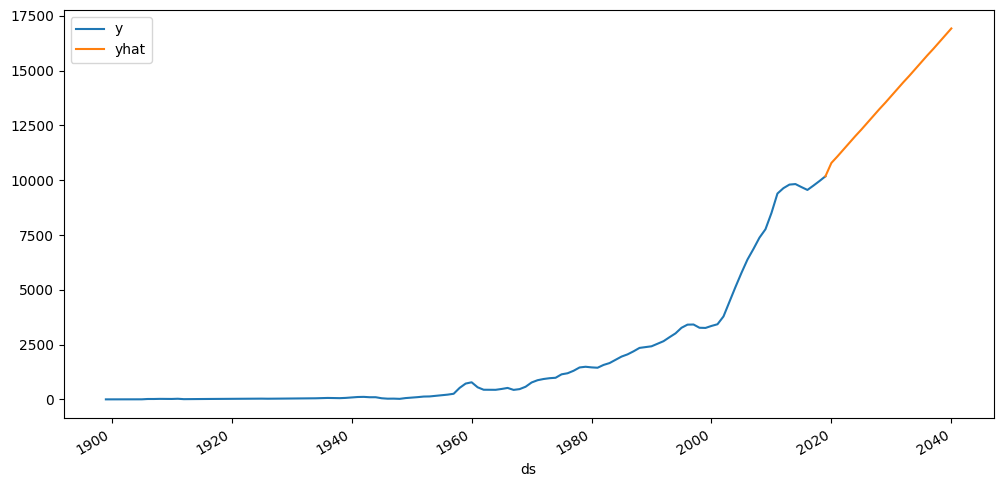

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_forecast(df, filename):
    fig = plt.figure(dpi=100)

    fig.set_facecolor("white")

    plot = df.plot(
        kind="line",
        x="ds",
        y=["y", "yhat"],
        figsize=(12,6),
        ax=fig.gca()
    );

    plot_fig = plot.get_figure()

    plot_fig.savefig(f'{filename}.png')

plot_forecast(combined_global, "global_co2_forecast")
plot_forecast(combined_country, "country_co2_forecast")